#### Group by ID (only to view not final utility)

In [6]:
import pandas as pd
import os
BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv_alternative.csv'


filename = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
print(filename)
df = pd.read_csv(filename)

id_counts = df['id'].value_counts().reset_index()
id_counts.columns = ['ID', 'Total Number']

print(id_counts.sort_values(by='ID', ascending=True))
# Save the result to a new CSV file
output_file_path = os.path.join(BASE_FOLDER_NAME, 'id_counts.csv')

id_counts.to_csv(output_file_path, index=False)

logs/conce_bbox.csv_alternative.csv
       ID  Total Number
85     14           191
192    15           118
500    16            53
212    33           112
514    78            49
..    ...           ...
446  5671            63
167  5692           128
582  5693            22
143  5697           138
572  5704            29

[593 rows x 2 columns]


### Data transformer CSV (Yolo) -> Feature Engineering (CSV)

In [12]:
import pandas as pd
import os

# Assuming previous setup
BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv_alternative.csv'
filename = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
df = pd.read_csv(filename)

# Calculate Area, Centroid_X, and Centroid_Y
df['Area'] = (df['x2'] - df['x1']) * (df['y2'] - df['y1'])
df['Centroid_X'] = ((df['x1'] + df['x2']) / 2).astype(int)
df['Centroid_Y'] = ((df['y1'] + df['y2']) / 2).astype(int)

# Selecting relevant columns and create a copy to avoid SettingWithCopyWarning
new_df = df[['id', 'Area', 'Centroid_X', 'Centroid_Y', 'frame_number', 'overlap', 'distance_to_center', 'score']].copy()

# Renaming columns
new_df.columns = ['id', 'area', 'Centroid_X', 'Centroid_Y', 'frame_number', 'overlap', 'distance_to_center', 'conf_score']

# Convert distance_to_center to int and round overlap and conf_score using .loc to avoid warnings
new_df.loc[:, 'distance_to_center'] = new_df['distance_to_center'].astype(int)
new_df.loc[:, 'overlap'] = new_df['overlap'].round(2)
new_df.loc[:, 'conf_score'] = new_df['conf_score'].round(2)

# Define new file name and save the modified DataFrame
new_file = CSV_FILE_PATH.split('.')[0] + '_area.csv'
new_file = os.path.join(BASE_FOLDER_NAME, new_file)
new_df.to_csv(new_file, index=False)


### Create CSV -> JSON with Random Image Distribute Linealrly

In [14]:
import os
import glob
import json
from sklearn.model_selection import KFold
import numpy as np

# Example usage
BASE_FOLDER_NAME = 'logs'
base_folder = '/home/diego/Documents/yolov7-tracker/imgs_conce'
k_folds = 4
n_images = 5
default_rate = '-'
JSON_FILE_NAME = 'selected_images.json'

def select_images_from_folds(base_folder, k_folds, n_images):
    results = []
    
    id_folders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    
    for folder in id_folders:
        images = sorted(glob.glob(f"{folder}/*.png"), key=lambda x: int(x.split('_')[-2]))
        
        # If there are not enough images to select from, select all images in the folder
        if len(images) < n_images * k_folds:
            for img_path in images:
                img_id = os.path.basename(folder)  # Assuming the folder name is the ID
                results.append({
                    "img": img_path,
                    "id": int(img_id),
                    "rate": default_rate
                })
            continue  # Skip to the next folder
        
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        for _, test_index in kf.split(images):
            selected_indices = np.random.choice(test_index, min(n_images, len(test_index)), replace=False)
            selected_images = np.array(images)[selected_indices]
            
            for img_path in selected_images:
                img_id = os.path.basename(folder)  # Assuming the folder name is the ID
                results.append({
                    "img": img_path,
                    "id": int(img_id),
                    "rate": default_rate
                })

    # Sort the results by 'id'
    sorted_results = sorted(results, key=lambda x: x['id'])
    
    return sorted_results



try:
    selected_images = select_images_from_folds(base_folder, k_folds, n_images)
    filename = os.path.join(BASE_FOLDER_NAME, JSON_FILE_NAME)
    # To save the result to a JSON file in sorted order by ID
    with open(filename, 'w') as f:
        json.dump(selected_images, f, indent=2)
except Exception as e:  # Generic exception handling, if needed
    print(f"An error occurred: {e}")


### READ JSON LABEL and Complete CSV (Lee el rate del JSON y lo pasa al CSV, para el modelo)

In [28]:
import os
import pandas as pd
import json

# Setup file paths
BASE_FOLDER_NAME = 'logs'
JSON_FILE = 'selected_images_MODEL.json'
JSON_FILE_PATH = os.path.join(BASE_FOLDER_NAME, JSON_FILE)
CSV_FILE_PATH = 'conce_bbox_area.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

# Load the CSV data into a DataFrame
df = pd.read_csv(CSV_FILE_PATH)

# Load the JSON data
with open(JSON_FILE_PATH, 'r') as file:
    json_data = json.load(file)

# Initialize a new column 'label' with default values (e.g., '-')
df['label'] = '-'

# Iterate over each object in the JSON data
for item in json_data:
    # Extract the frame_number from the image path
    # Assuming the format is always like the provided examples, 
    # and the frame_number is the part just before the last underscore
    frame_number = int(item['img'].split('_')[3])
    # Get the ID directly from the item
    id_ = item['id']
    # Get the rate
    rate = item['rate']
    
    # Find the row that matches both ID and frame_number, then update the 'label' column
    df.loc[(df['id'] == id_) & (df['frame_number'] == frame_number), 'label'] = rate

# Optional: Save the updated DataFrame to a new CSV file
updated_csv_file_path = os.path.join(BASE_FOLDER_NAME, 'updated_' + CSV_FILE_PATH.split('/')[-1])
df.to_csv(updated_csv_file_path, index=False)


### Model Creation

In [29]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier


BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'updated_conce_bbox_area.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

NEW_CSV = os.path.join(BASE_FOLDER_NAME, 'updated_conce_bbox_area_model.csv')

# Load your data
df = pd.read_csv(CSV_FILE_PATH)

# Preprocess your data
# Convert '-' labels to None for easier handling
df['label'] = df['label'].apply(lambda x: None if x == '-' else x).astype(float)

# Separate the dataset into training and prediction sets
train_df = df.dropna(subset=['label'])
predict_df = df[df['label'].isna()]

# Define features and target
features = ['area', 'Centroid_X', 'Centroid_Y', 'frame_number', 'overlap', 'distance_to_center', 'conf_score']
target = 'label'

# Splitting the training data for validation
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label'] = predicted_labels
predict_df['model_confidence'] = predicted_confidences

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(NEW_CSV, index=False)

print("Updated CSV saved successfully.")


Validation Accuracy: 0.9722222222222222


/tmp/ipykernel_8094/1637288565.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['model_label'] = predicted_labels
/tmp/ipykernel_8094/1637288565.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['model_confidence'] = predicted_confidences


Updated CSV saved successfully.


### Show model results predictions

/tmp/ipykernel_8094/3051236343.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['file_path'] = df_filtered.apply(construct_file_path, axis=1)


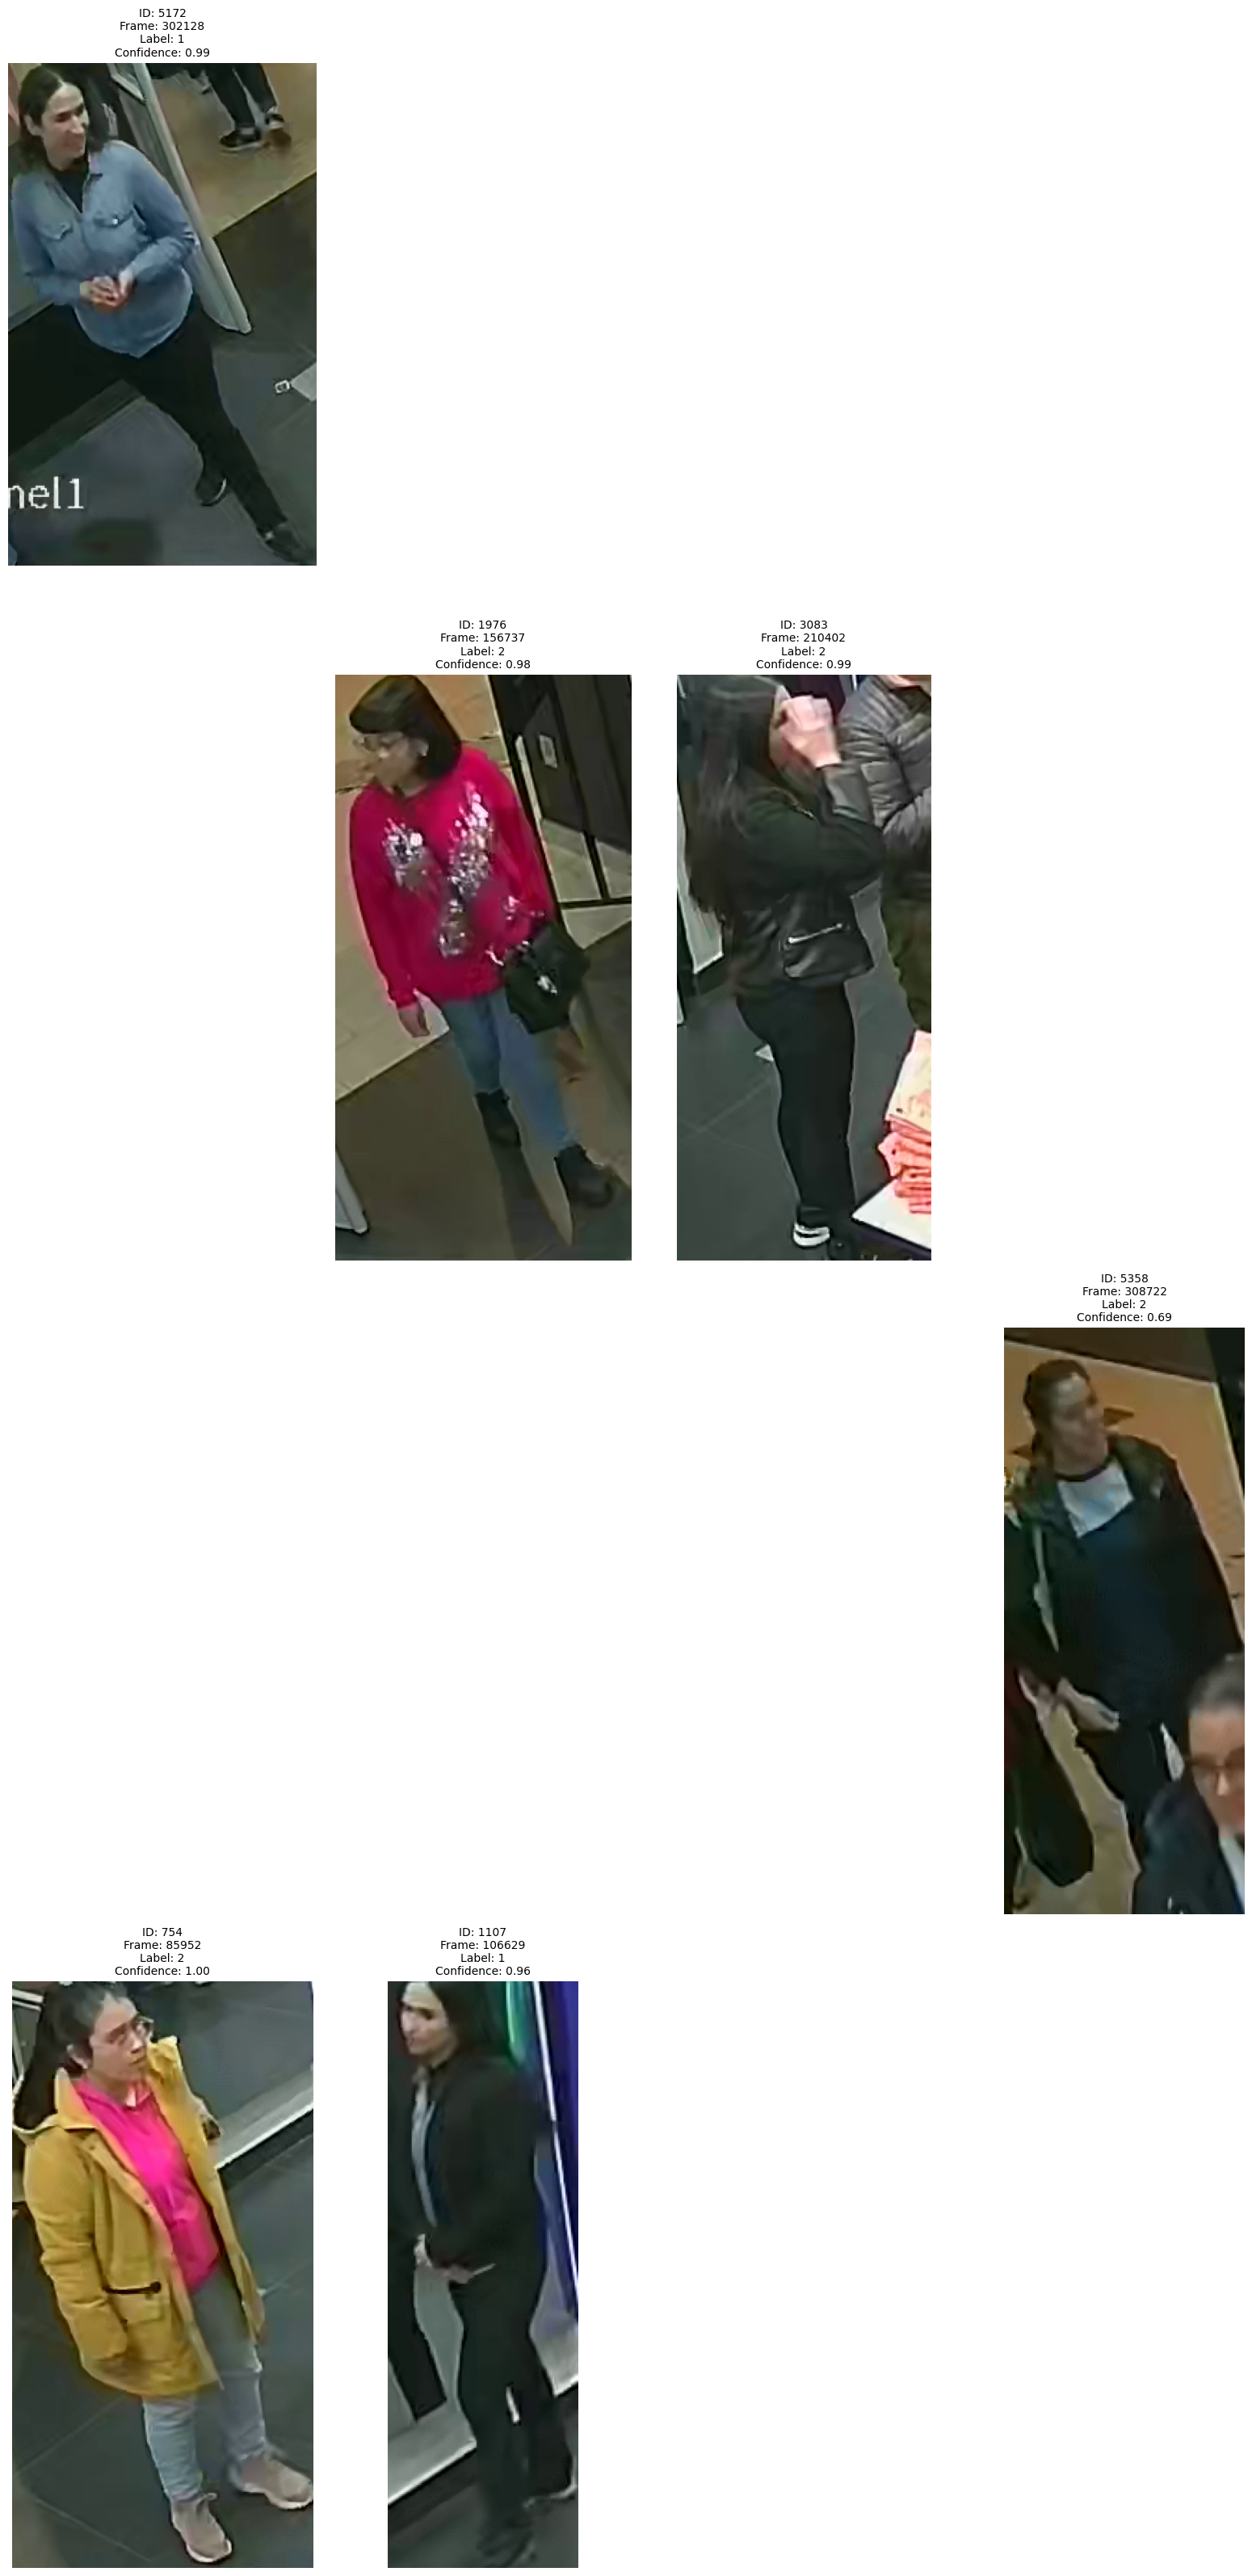

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Read the CSV file
BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'updated_conce_bbox_area.csv'
NEW_CSV = os.path.join(BASE_FOLDER_NAME, 'updated_conce_bbox_area_model.csv')

def find_matching_file_path(directory, filename_start):
    """
    Searches for files in the specified directory that start with the given filename start string.
    
    :param directory: The directory to search within.
    :param filename_start: The initial part of the file name to match.
    :return: The full path to the first matching file, or None if no match is found.
    """
    # Construct the search pattern
    search_pattern = os.path.join(directory, filename_start + "*.png")
    
    # Use glob to find all files matching the pattern
    matching_files = glob.glob(search_pattern)
    
    # Return the first matching file path, if any
    if matching_files:
        return matching_files[0]  # Return full path of the first match
    else:
        return ''  # No match found

df = pd.read_csv(NEW_CSV)

# Filter rows where `model_label` and `model_confidence` are not null
df_filtered = df.dropna(subset=['model_label', 'model_confidence'])

# Filtering rows where frame_number % 3 == 0
#df_filtered = df_filtered[df_filtered['frame_number'] % 3 == 0]

# Base path for the images
base_path = "/home/diego/Documents/yolov7-tracker/imgs_conce"

# Function to construct the file path
def construct_file_path(row):
    return os.path.join(base_path, str(int(row['id'])))

# Apply the function to construct file paths
df_filtered['file_path'] = df_filtered.apply(construct_file_path, axis=1)

# Randomly select 50 images if available, or take the whole dataset if less than 50
sample_size = min(20, len(df_filtered))
sampled_df = df_filtered.sample(n=sample_size)

rows = (sample_size + 4) // 5  # Calculate rows needed for the sample size, adjust the denominator to change columns
cols = 5 if sample_size > 5 else sample_size  # Adjust columns based on sample size

fig, axs = plt.subplots(rows, cols, figsize=(20, 8 * rows))  # Adjust figsize dynamically
axs = axs.flatten()  # Flatten to easily loop over if it's a grid

for i in range(len(axs)):
    if i < sample_size:
        row = sampled_df.iloc[i]
        img_path = find_matching_file_path(row.file_path, f"img_{row.id}_{row.frame_number}")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].set_title(f"ID: {row.id}\nFrame: {row.frame_number}\nLabel: {int(row.model_label)}\nConfidence: {row.model_confidence:.2f}", fontsize=10)
            axs[i].axis('off')
        else:
            axs[i].set_visible(False)
    else:
        axs[i].set_visible(False)  # Hide unused subplots

plt.tight_layout()
plt.show()
